# Working with staellite imagery: rasterio

> ***Rasterio*** reads and writes geospatial raster data.



[Read more about rasterio here](https://rasterio.readthedocs.io/en/latest/quickstart.html)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
import numpy as np

In [4]:
np.random.seed(100)

src = rasterio.open("South_coast.tif")

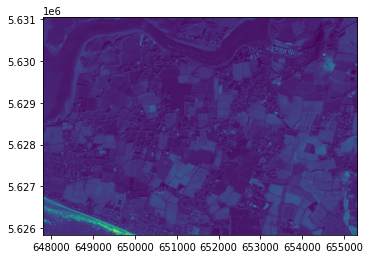

In [5]:
plot.show(src)

In [6]:
print(src.shape)

(519, 751)


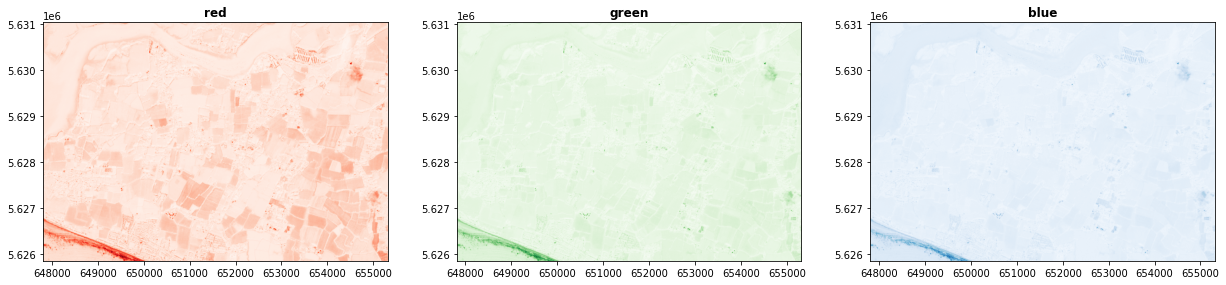

In [7]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
plot.show((src, 1), ax=axr, cmap='Reds', title='red')
plot.show((src, 2), ax=axg, cmap='Greens', title='green')
plot.show((src, 3), ax=axb, cmap='Blues', title='blue')

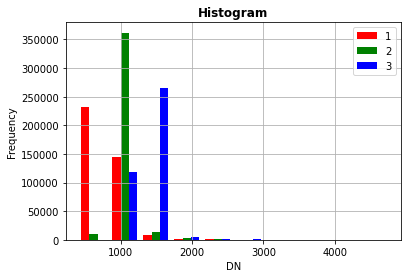

In [8]:
## lets plot a histogram
plot.show_hist(src)

In [9]:
## metadata
src.meta

{'count': 3,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 519,
 'nodata': None,
 'transform': Affine(9.99532148290051, 0.0, 647804.602318258,
       0.0, -10.008132029461148, 5631039.60410191),
 'width': 751}

In [10]:
print(type(src))

<class 'rasterio.io.DatasetReader'>


**Transformation of the input data**

The typical geospatial coordinate reference system is defined on a cartesian plane with the 0,0 origin in the bottom left and X and Y increasing as you go up and to the right. But raster data, coming from its image processing origins, uses a different referencing system to access pixels. We refer to rows and columns with the 0,0 origin in the upper left and rows increase and you move down while the columns increase as you go right. Still a cartesian plane but not the same one.

![pic](https://www.perrygeo.com/assets/img/xyrowcol.png)

The .transform property returns an instance of an Affine object. This is essentially an augmented affine transformation matrix, where the 3x3 matrix always has a bottom row [0 0 1].

| x' |   | a  b  c | | x |

| y' | = | d  e  f | | y |

| 1  |   | 0  0  1 | | 1 |


The 2x3 matrix representation only shows the six coefficients (a, b, c, d, e, f) that represent this information. These coefficients are very similar to a 6-line world file, where the only difference is that a world file registers the offset to the centre of the origin cell, whereas GDAL (and rasterio) register the corner of the origin cell.

- a = width of a pixel
- b = row rotation (typically zero)
- c = x-coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)
- f = y-coordinate of the of the upper-left corner of the upper-left pixel

[Read more here[(https://www.perrygeo.com/python-affine-transforms.html)




In [12]:
print(src.transform)

| 10.00, 0.00, 647804.60|
| 0.00,-10.01, 5631039.60|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3847, 'height': 2272, 'count': 3, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600140.0,
       0.0, -10.0, 5626000.0), 'tiled': False, 'interleave': 'pixel'}


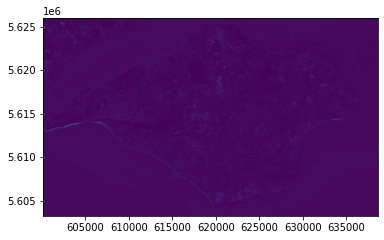

In [14]:
src2 = rasterio.open("out_byte.tif")
profile = src2.profile
print(profile)

plot.show(src2)

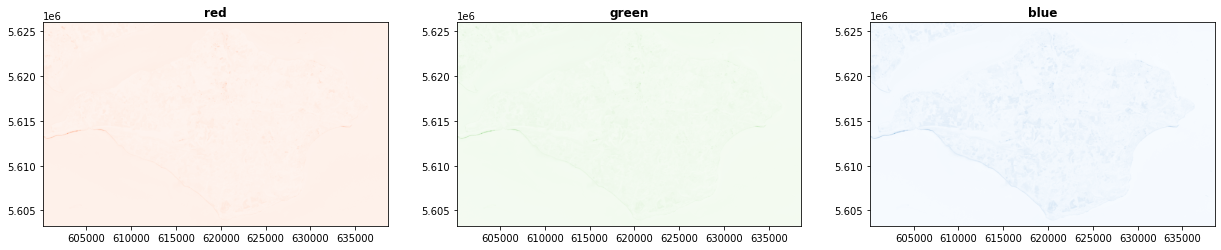

In [15]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
plot.show((src2, 1), ax=axr, cmap='Reds', title='red')
plot.show((src2, 2), ax=axg, cmap='Greens', title='green')
plot.show((src2, 3), ax=axb, cmap='Blues', title='blue')

In [16]:
print(src2)

<open DatasetReader name='out_byte.tif' mode='r'>


In [17]:
arr = src2.read()
print(arr.shape)
band1 = arr[0,:,:]
band2 = arr[1,:,:]
band3 = arr[1,:,:]

## example of transpose arrays example if needed
x = np.ones((1, 2, 3))
np.transpose(x, (2, 1, 0)).shape

(3, 2272, 3847)


(3, 2, 1)

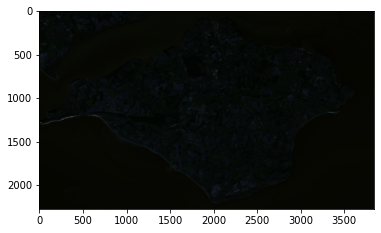

In [18]:
from scipy.signal import medfilt ## https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.medfilt.html
filtered = medfilt(arr, (1, 5, 5)).astype('uint8')
plot.show(filtered)

didn't appear to make much difference, plot the histogram and try other stretches

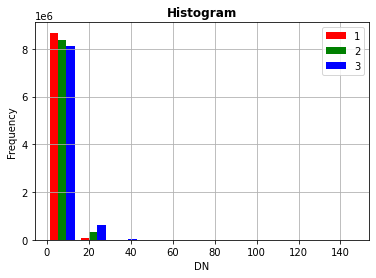

In [19]:
plot.show_hist(filtered)

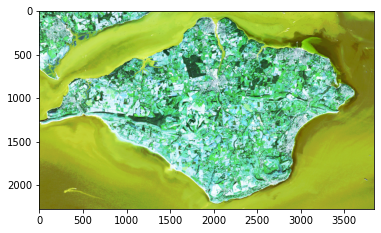

In [20]:
from skimage import exposure
img_eq = exposure.equalize_hist(arr)
plot.show(img_eq)

over exposed! try a percentile clip

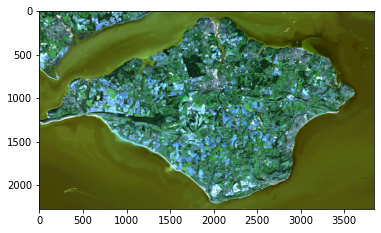

In [21]:
p2, p98 = np.percentile(arr, (2, 98))
img_rescale = exposure.rescale_intensity(arr, in_range=(p2, p98))
plot.show(img_rescale)

bands are in wrong order though!

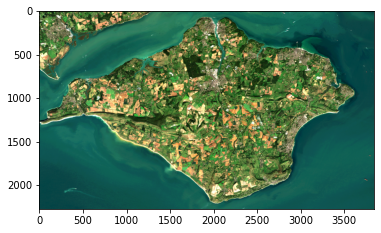

In [22]:
red = img_rescale[2,:,:]
green = img_rescale[1,:,:]
blue = img_rescale[0,:,:]

rgb = np.stack([red, green, blue])
plot.show(rgb)

perfect now write out with Rasterio

In [23]:
print(rgb.shape)

profile = src2.profile
print(profile)
#profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

out_profile = src2.profile.copy()

with rasterio.open('out_rasterio.tif', 'w', **out_profile) as dst:
    dst.write(rgb)


(3, 2272, 3847)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3847, 'height': 2272, 'count': 3, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600140.0,
       0.0, -10.0, 5626000.0), 'tiled': False, 'interleave': 'pixel'}
